In [1]:
import os
import torch
import torch.nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torchvision.utils as utils
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image

In [2]:
def visualize_activation_maps(input, model):
    I = utils.make_grid(input, nrow=1, normalize=True, scale_each=True)
    img = I.permute((1, 2, 0)).cpu().numpy()

    conv_results = []
    x = input
    acti_map = []
    for idx, operation in enumerate(model.features):
        x = operation(x)
        if idx in {1, 4, 7, 9, 11}:
            conv_results.append(x)
    for i in range(5):
        conv_result = conv_results[i]
 
        mean_acti_map = torch.mean(conv_result, dim=1, keepdim=True)
   
        mean_acti_map = F.interpolate(mean_acti_map, size=[224,224], mode='bilinear', align_corners=False)
        
        map_grid = utils.make_grid(mean_acti_map, nrow=1, normalize=True, scale_each=True)

        map_grid = map_grid.permute((1, 2, 0)).mul(255).byte().cpu().numpy()

        map_grid = cv2.applyColorMap(map_grid, cv2.COLORMAP_JET)
        map_grid = cv2.cvtColor(map_grid, cv2.COLOR_BGR2RGB)
        map_grid = np.float32(map_grid) / 255

        visual_acti_map = 0.6 * img + 0.4 * map_grid
        tensor_visual_acti_map = torch.from_numpy(visual_acti_map).permute(2, 0, 1)
        acti_map.append(tensor_visual_acti_map)
        file_name_visual_acti_map = 'conv{}_activation_map.jpg'.format(i+1)
        utils.save_image(tensor_visual_acti_map, file_name_visual_acti_map)

    final_tensor=torch.stack(acti_map,0) 
    image_batch = utils.make_grid(final_tensor,padding = 0)
    plt.imshow(np.transpose(image_batch, (1, 2, 0))) 
    plt.show()

In [3]:
data_transforms = transforms.Compose([
        transforms.Resize((224,224)),          
        transforms.ToTensor(),              
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])

In [4]:
test_image_dir = './alexnet_images'
test_image_filepath = os.path.join(test_image_dir, 'panda.jpg')
img = Image.open(test_image_filepath)
transformed_img = data_transforms(img)
batch_img = torch.unsqueeze(transformed_img, 0)

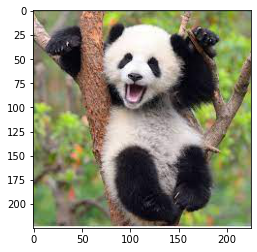

In [5]:
plt.imshow(img)  
plt.show()

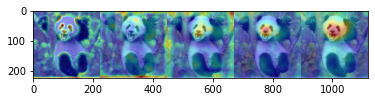

In [6]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()
output = alexnet(batch_img)
visualize_activation_maps(batch_img, alexnet)

In [7]:
with open('class_names_ImageNet.txt') as labels:
    classes = [i.strip() for i in labels.readlines()]

In [8]:
sorted, indices = torch.sort(output, descending=True)
percentage = F.softmax(output, dim=1)[0] * 100.0
results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
for i in range(5):
    print('{}: {:.4f}%'.format(results[i][0], results[i][1]))

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 77.2142%
indri, indris, Indri indri, Indri brevicaudatus: 13.5417%
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens: 5.1589%
titi, titi monkey: 1.1513%
gibbon, Hylobates lar: 0.5765%
